In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
static_fields = xr.open_dataset(r'/nesi/project/niwa03712/group_shared/Emulator_training_data/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc')

### Creating Figure 4
Loading the Annual Maxima (see create_annual_maximum_for_figure4.ipynb on how to process raw data).


In [16]:
t_dset =xr.open_dataset('/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/internal_variability_data/Multi_Model_Decomposition_tasmax_v160625_raw.nc')
# model specific dataset (4 ssps and 20 CMIP6 GCMs)
t_dset_le = xr.open_dataset('/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/internal_variability_data/Multi_Model_Decomposition_tasmax_LE_IV_v160625_raw.nc')
# two large ensembles
pr_dset =xr.open_dataset('/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/internal_variability_data/Multi_Model_Decomposition_pr_v160625_raw.nc')
# model specific dataset

pr_dset_le = xr.open_dataset('/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/internal_variability_data/Multi_Model_Decomposition_pr_LE_IV_v160625_raw.nc')
# two large ensembles

In [17]:
static_fields = xr.open_dataset(r'/nesi/project/niwa03712/group_shared/Emulator_training_data/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc')

In [18]:
# merged_dset = merged_dset_updated = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/Low_res_ACCESS-ESM1-5_ensemble.nc')
# # Loa
# merged_dset= merged_dset.interp(lat = static_fields.lat, lon = static_fields.lon, method ='nearest')

In [19]:
# merged_dset['TXX_IV'] = merged_dset['TXx'] - merged_dset['TXx'].sel(year = slice("1995","2014")).mean("year")

In [20]:
# merged_dset['RX1Day_IV'] = 100*(merged_dset['Rx1day'] - merged_dset['Rx1day'].sel(year = slice("1995","2014")).mean("year"))/merged_dset['Rx1day'].sel(year = slice("1995","2014")).mean("year")

In [62]:
def compute_decomposition_annual(
    model_scenario,
    IV_ensemble,
    merged_dset,
    varname="TXX_MME",
    dim="year",
    degree=2,
    varname_iv="TXX_IV",
    model_anoms='anom'
):
    """
    Decomposes uncertainty in climate projections into internal variability, 
    model uncertainty, and scenario uncertainty using rolling decadal means.

    Parameters
    ----------
    model_scenario : xarray.Dataset
        Contains high-resolution downscaled outputs (e.g., GANs) for multiple GCMs and scenarios.
    IV_ensemble : xarray.Dataset
        Contains repeated RCM simulations with the same GCM boundary conditions to estimate internal variability.
    merged_dset : xarray.Dataset
        Contains both low-resolution GCM and RCM-based fields (not directly used here, only retained).
    varname : str, optional
        Name of the variable in `model_scenario` (default is "TXX_MME").
    dim : str, optional
        Dimension along which to compute rolling mean and trend (default is "year").
    degree : int, optional
        Degree of polynomial used to fit the forced trend (default is 2).
    varname_iv : str, optional
        Variable name for internal variability dataset (default is "TXX_IV").
    model_anoms : str, optional
        Defines anomaly computation: "anom" (absolute) or "percentage" (default is "anom").

    Returns
    -------
    I_model : float
        Residual interannual internal variability (after removing forced trend).
    M : float
        Model uncertainty component.
    S : float
        Scenario uncertainty component.
    I_trend_A : float
        Forced internal variability for ACCESS-ESM1-5.
    I_trend_C : float
        Forced internal variability for CanESM5.
    I_raw_A : float
        Total internal variability (including forced + internal noise) for ACCESS-ESM1-5.
    I_raw_C : float
        Total internal variability for CanESM5.
    fitted_curve : xarray.DataArray
        Fitted polynomial trend over time for `model_scenario`.
    """

    # Convert time coordinate to year
    try:
        model_scenario['time'] = model_scenario.time.dt.year
    except:
        print("passed")
    try:
        IV_ensemble['time'] = IV_ensemble.time.dt.year
    except:
        print("passed")

    # Compute climatologies over 1995–2014
    clim_model = model_scenario.sel(year=slice("1986", "2005")).mean("year")
    clim_IV = IV_ensemble.sel(year=slice("1986", "2005")).mean("year")

    # Compute anomalies
    if model_anoms == 'anom':
        model_scenario = model_scenario - clim_model
        IV_ensemble = IV_ensemble - clim_IV
    elif model_anoms == 'percentage':
        model_scenario = 100 * (model_scenario - clim_model) / clim_model
        IV_ensemble = 100 * (IV_ensemble - clim_IV) / clim_IV

    # Smooth with decadal rolling means
    model_scenario = model_scenario[varname].rolling({dim: 10}, min_periods=6).mean().dropna(dim)

    # Fit polynomial to smoothed signal (forced component)
    fitted_uncertainty = model_scenario.isel({dim: slice(1, -1)}).polyfit(dim, degree, skipna=True)
    fitted_curve = xr.polyval(model_scenario[dim], fitted_uncertainty.polyfit_coefficients)

    # Compute residuals = internal variability
    residuals = model_scenario - fitted_curve
    I_model = residuals.var(dim).mean(["GCM", "ssp"])

    # Decompose forced response variance
    M = fitted_curve.var("GCM").mean("ssp")  # Model uncertainty
    S = fitted_curve.mean("GCM").var("ssp")  # Scenario uncertainty

    # Internal variability from repeated simulations
    IV_ensemble = IV_ensemble[varname_iv].rolling({dim: 10}, min_periods=6).mean().dropna(dim)

    # Fit polynomial to IV ensemble
    fitted_uncertainty_IV = IV_ensemble.isel({dim: slice(1, -1)}).polyfit(dim, degree, skipna=True)
    fitted_curve_IV = xr.polyval(IV_ensemble[dim], fitted_uncertainty_IV.polyfit_coefficients)

    # Forced variability component (trend) for specific GCMs
    I_trend_A = fitted_curve_IV.sel(GCM_variant=(IV_ensemble.GCM == 'ACCESS-ESM1-5')).var("GCM_variant")
    I_trend_C = fitted_curve_IV.sel(GCM_variant=(IV_ensemble.GCM == 'CanESM5')).var("GCM_variant")

    # Raw internal variability (total)
    I_raw_A = IV_ensemble.sel(GCM_variant=(IV_ensemble.GCM == 'ACCESS-ESM1-5')).var("GCM_variant")
    I_raw_C = IV_ensemble.sel(GCM_variant=(IV_ensemble.GCM == 'CanESM5')).var("GCM_variant")

    return I_model, M, S, I_trend_A, I_trend_C, I_raw_A, I_raw_C, fitted_curve


In [64]:
def compute_decomposition_decadal(
    model_scenario,
    IV_ensemble,
    merged_dset,
    varname="TXX_MME",
    dim="year",
    degree=2,
    varname_iv="TXX_IV",
    model_anoms='anom'
):
    """
    Decomposes uncertainty in decadal-scale extremes (e.g., 10-year max) 
    into internal variability, model uncertainty, and scenario uncertainty.

    Parameters
    ----------
    model_scenario : xarray.Dataset
        Contains high-resolution downscaled data (e.g., GANs) for multiple GCMs and scenarios.
    IV_ensemble : xarray.Dataset
        Repeated RCM simulations for internal variability estimation.
    merged_dset : xarray.Dataset
        Combined dataset including GCM and IV simulations (not directly used).
    varname : str, optional
        Variable name in `model_scenario` (default: "TXX_MME").
    dim : str, optional
        Dimension along which to compute rolling statistics (default: "year").
    degree : int, optional
        Polynomial degree used to fit the forced trend (default: 2).
    varname_iv : str, optional
        Variable name for internal variability ensemble (default: "TXX_IV").
    model_anoms : str, optional
        Method of anomaly computation: "anom" for absolute or "percentage" (default: "anom").

    Returns
    -------
    I_model : float
        Residual internal variability from smoothed decadal extremes.
    M : float
        Model uncertainty component.
    S : float
        Scenario uncertainty component.
    I_trend_A : float
        Forced variability component (trend) from ACCESS-ESM1-5.
    I_trend_C : float
        Forced variability from CanESM5.
    I_raw_A : float
        Raw internal variability from ACCESS-ESM1-5.
    I_raw_C : float
        Raw internal variability from CanESM5.
    fitted_curve : xarray.DataArray
        Fitted polynomial trend for model_scenario.
    """

    # Convert time to years
    try:
        model_scenario['time'] = model_scenario.time.dt.year
    except:
        print("passed")
    try:
        IV_ensemble['time'] = IV_ensemble.time.dt.year
    except:
        print("passed")

    # Compute decadal climatology over reference period
    clim_model = model_scenario.rolling({dim: 10}, min_periods=6).max().sel(year=slice("1986", "2005")).mean("year")
    clim_IV = IV_ensemble.rolling({dim: 10}, min_periods=6).max().sel(year=slice("1986", "2005")).mean("year")

    # Compute anomalies
    if model_anoms == 'anom':
        model_scenario = model_scenario - clim_model
        IV_ensemble = IV_ensemble - clim_IV
    elif model_anoms == 'percentage':
        model_scenario = 100 * (model_scenario - clim_model) / clim_model
        IV_ensemble = 100 * (IV_ensemble - clim_IV) / clim_IV

    # Compute rolling decadal max and apply additional smoothing
    model_scenario = model_scenario[varname].rolling({dim: 10}, min_periods=6).max().dropna(dim)
    model_scenario = model_scenario.rolling({dim: 10}, min_periods=6).mean().dropna(dim)

    # Fit forced polynomial trend
    fitted_uncertainty = model_scenario.isel({dim: slice(1, -1)}).polyfit(dim, degree, skipna=True)
    fitted_curve = xr.polyval(model_scenario[dim], fitted_uncertainty.polyfit_coefficients)

    # Residual = internal variability (after trend removed)
    residuals = model_scenario - fitted_curve
    I_model = residuals.var([dim, "ssp"]).mean("GCM")

    # Forced variance decomposition
    M = fitted_curve.var("GCM").mean("ssp")  # Model uncertainty
    S = fitted_curve.mean("GCM").var("ssp")  # Scenario uncertainty

    # Process IV ensemble: rolling max then rolling mean
    IV_ensemble = IV_ensemble[varname_iv].rolling({dim: 10}, min_periods=6).max().dropna(dim)
    IV_ensemble = IV_ensemble.rolling({dim: 10}, min_periods=6).mean()

    # Fit forced trend to internal variability ensemble
    fitted_uncertainty_IV = IV_ensemble.isel({dim: slice(1, -1)}).polyfit(dim, degree, skipna=True)
    fitted_curve_IV = xr.polyval(IV_ensemble[dim], fitted_uncertainty_IV.polyfit_coefficients)

    # Forced variability components
    I_trend_A = fitted_curve_IV.sel(GCM_variant=(IV_ensemble.GCM == 'ACCESS-ESM1-5')).var("GCM_variant")
    I_trend_C = fitted_curve_IV.sel(GCM_variant=(IV_ensemble.GCM == 'CanESM5')).var("GCM_variant")

    # Raw internal variability
    I_raw_A = IV_ensemble.sel(GCM_variant=(IV_ensemble.GCM == 'ACCESS-ESM1-5')).var("GCM_variant")
    I_raw_C = IV_ensemble.sel(GCM_variant=(IV_ensemble.GCM == 'CanESM5')).var("GCM_variant")

    return I_model, M, S, I_trend_A, I_trend_C, I_raw_A, I_raw_C, fitted_curve


/nesi/project/niwa00018/rampaln/envs/ml_env_v2/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


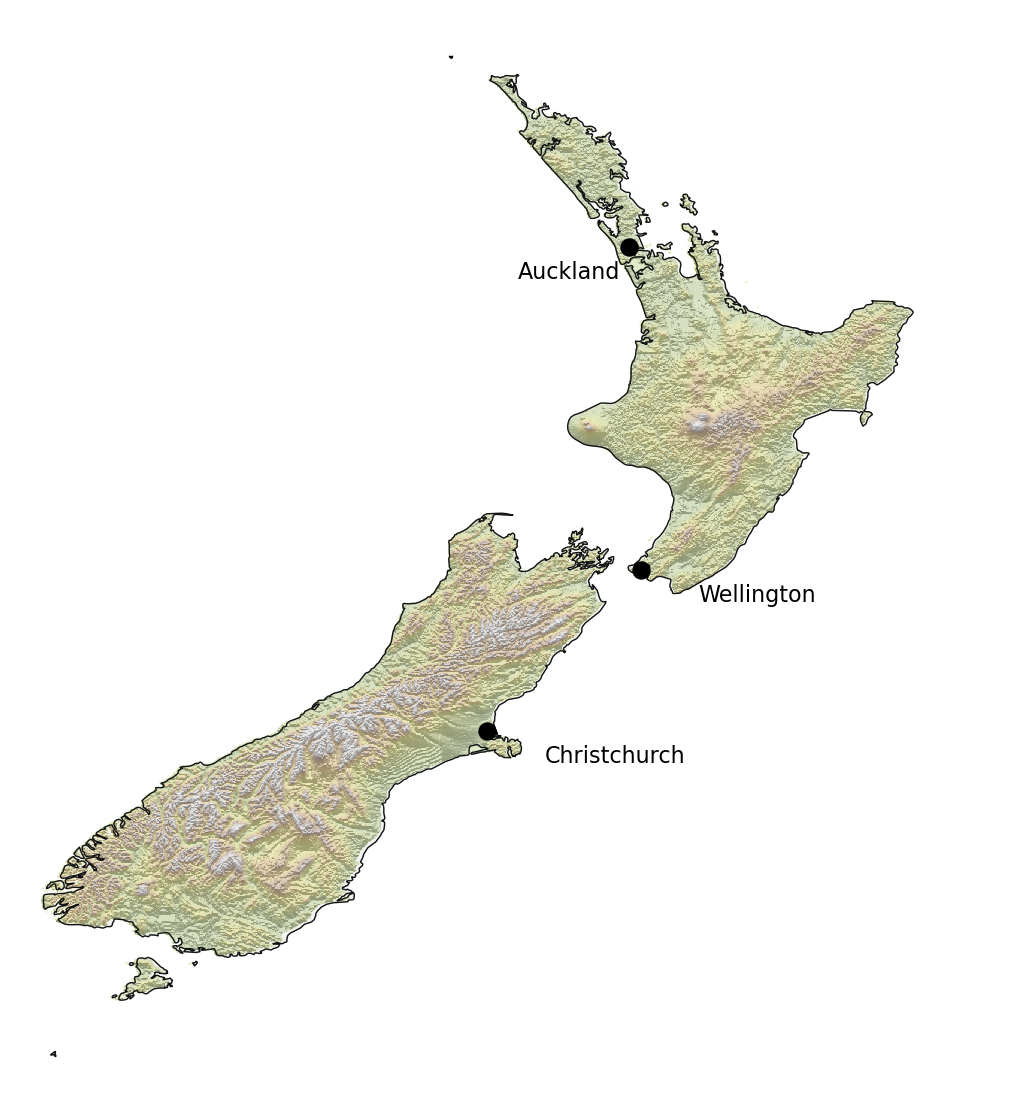

In [65]:
from matplotlib.colors import LinearSegmentedColormap
import earthpy.spatial as es
import cartopy.crs as ccrs
hillshade_dset = xr.open_dataset(r'/nesi/project/niwa00018/gibsonp/dload_data/global_topo_1km/topo_NZ_1km.nc')
hillshade = es.hillshade(hillshade_dset.topo.values, azimuth=0, altitude=45)
hillshade_dset['hillshade'] = (('Y','X'), hillshade)


#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/Rx1day_spatial_figre_dfj.pdf', dpi =500, bbox_inches ='tight')
regions = {'Auckland': (-36.7928, 174.6131),
 'Wellington': (-41.2924, 174.7787),
 'Christchurch': (-43.532, 172.6366)}
import numpy as np
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap colors (approximated from the image)
colors = [    # Slightly lighter green
    (0.0,  "yellowgreen"), # Yellowish green
    (0.25,  "yellow"),     # Bright yellow
    (0.5, "orange"),     # Warm orange
    (0.75,  "saddlebrown"), # Reddish-brown
    (1.0,  "white")       # Lightest color on the far right
]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)

fig = plt.figure(figsize=(16, 14))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([160, 180, -53, -28], crs=ccrs.PlateCarree())
hillshade_dset.hillshade.plot(ax = ax_map, transform = ccrs.PlateCarree(), cmap ='Greys_r', alpha =0.475, levels =50, zorder =3, add_colorbar =False)
hillshade_dset.topo.plot(ax = ax_map, transform = ccrs.PlateCarree(), cmap =custom_cmap, alpha =0.22, levels =50, zorder =4, add_colorbar =False, vmax =1500)
# Add map features
ax_map.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, zorder =4, fc ='gray')
ax_map.add_feature(cfeature.LAND, linewidth=1, zorder =4, fc ='gray', alpha =0.1)
ax_map.add_feature(cfeature.BORDERS, linestyle=':', zorder =4)
ax_map.set_frame_on(False)
for region, (lat, lon) in regions.items():
    if region == 'Auckland':
        ax_map.text(lon-1.55, lat-0.45, region, transform =ccrs.PlateCarree(), fontsize =16, zorder =12, color ='k')#, weight ='bold')
    else:
    #x_violin.
        ax_map.text(lon+0.8, lat-0.45, region, transform =ccrs.PlateCarree(), fontsize =16, zorder =12, color ='k')#, weight ='bold')
    ax_map.scatter(lon, lat, transform =ccrs.PlateCarree(), s=150, color ='k', marker ='o', zorder=14)
ax_map.set_extent([166, 180, -48.5, -33.5], crs = ccrs.PlateCarree())
#fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Hawkins_Sutton/NZ_topography.png', dpi =500, bbox_inchest ='tight')

In [66]:
I_model_rx1day, M_rx1day, S_rx1day, I_trend_A_rx1day, I_trend_C_rx1day, I_raw_A_rx1day, I_raw_C_rx1day,fitted_rx1day = compute_decomposition_annual(pr_dset.where(static_fields.orog>0, np.nan).mean(["lat","lon"]),
                                                                                              pr_dset_le.where(static_fields.orog>0, np.nan).mean(["lat","lon"]),merged_dset.where(static_fields.orog>0, np.nan).mean(["lat","lon"]), varname = "Rx1day_MME", dim ="year", degree =2, varname_iv = "RX1Day_IV")
I_model_rx1day_regional, M_rx1day_regional, S_rx1day_regional, I_trend_A_rx1day_regional, I_trend_C_rx1day_regional, I_raw_A_rx1day_regional, I_raw_C_rx1day_regional,fitted_T_rx1day_regional = compute_decomposition_annual(pr_dset,
                                                                                              pr_dset_le,merged_dset, varname = "Rx1day_MME", dim ="year", degree =2, varname_iv = "RX1Day_IV", model_anoms ='anom')

passed
passed
passed
passed


In [67]:
I_model_txx, M_txx, S_txx, I_trend_A_txx, I_trend_C_txx, I_raw_A_txx, I_raw_C_txx,fitted_txx = compute_decomposition_annual(t_dset.where(static_fields.orog>0, np.nan).mean(["lat","lon"]),
                                                                                              t_dset_le.where(static_fields.orog>0, np.nan).mean(["lat","lon"]),merged_dset.where(static_fields.orog>0, np.nan).mean(["lat","lon"]), varname = "TXX_MME", dim ="year", degree =2, varname_iv = "TXX_IV")
I_model_txx_regional, M_txx_regional, S_txx_regional, I_trend_A_txx_regional, I_trend_C_txx_regional, I_raw_A_txx_regional, I_raw_C_txx_regional,fitted_T_txx_regional = compute_decomposition_annual(t_dset,
                                                                                              t_dset_le,merged_dset, varname = "TXX_MME", dim ="year", degree =2, varname_iv = "TXX_IV", model_anoms ='anom')

passed
passed
passed
passed


In [68]:
I_model_rx1day_max, M_rx1day_max, S_rx1day_max, I_trend_A_rx1day_max, I_trend_C_rx1day_max, I_raw_A_rx1day_max, I_raw_C_rx1day_max,fitted_rx1day_max = compute_decomposition_decadal(pr_dset.where(static_fields.orog>0, np.nan).mean(["lat","lon"]),
                                                                                              pr_dset_le.where(static_fields.orog>0, np.nan).mean(["lat","lon"]), merged_dset, varname = "Rx1day_MME", dim ="year", degree =2, varname_iv = "RX1Day_IV")
I_model_rx1day_regional_max, M_rx1day_regional_max, S_rx1day_regional_max, I_trend_A_rx1day_regional_max, I_trend_C_rx1day_regional_max, I_raw_A_rx1day_regional_max, I_raw_C_rx1day_regional_max,fitted_T_rx1day_regional_max = compute_decomposition_decadal(pr_dset,
                                                                                              pr_dset_le,merged_dset, varname = "Rx1day_MME", dim ="year", degree =2, varname_iv = "RX1Day_IV", model_anoms ='anom')

passed
passed
passed
passed


In [69]:
I_model_txx_max, M_txx_max, S_txx_max, I_trend_A_txx_max, I_trend_C_txx_max, I_raw_A_txx_max, I_raw_C_txx_max,fitted_txx_max = compute_decomposition_decadal(t_dset.where(static_fields.orog>0, np.nan).mean(["lat","lon"]),
                                                                                              t_dset_le.where(static_fields.orog>0, np.nan).mean(["lat","lon"]), merged_dset, varname = "TXX_MME", dim ="year", degree =2, varname_iv = "TXX_IV")
I_model_txx_regional_max, M_txx_regional_max, S_txx_regional_max, I_trend_A_txx_regional_max, I_trend_C_txx_regional_max, I_raw_A_txx_regional_max, I_raw_C_txx_regional_max,fitted_T_txx_regional_max = compute_decomposition_decadal(t_dset,
                                                                                              t_dset_le, merged_dset, varname = "TXX_MME", dim ="year", degree =2, varname_iv = "TXX_IV", model_anoms ='anom')

passed
passed
passed
passed


In [70]:
def create_fraction_arr(I, S, M, I_static):
    T = S + M + I
    S_ = (S/T).to_dataset(name = 'Scenario')
    I_ = (I/T).to_dataset(name = 'Internal Variability')
    M_ = (M/T).to_dataset(name = 'Model')
    T = T.to_dataset(name = 'Total')
    I_static = I_static.to_dataset(name = 'Static I')
    merged = xr.merge([S_, I_, M_, T, I_static])
    return merged
    

In [71]:
merged_tx10 = create_fraction_arr(1/2*(I_raw_C_txx_regional_max + I_raw_A_txx_regional_max), S_txx_regional_max, M_txx_regional_max, I_model_txx_regional_max)
merged_rx10 = create_fraction_arr(1/2*(I_raw_C_rx1day_regional_max + I_raw_A_rx1day_regional_max), S_rx1day_regional_max, M_rx1day_regional_max, I_model_rx1day_regional_max)
merged_rx1day = create_fraction_arr(1/2*(I_raw_C_rx1day_regional + I_raw_A_rx1day_regional), S_rx1day_regional, M_rx1day_regional, I_model_rx1day_regional)
merged_txx = create_fraction_arr(1/2*(I_raw_C_txx_regional + I_raw_A_txx_regional), S_txx_regional, M_txx_regional, I_model_txx_regional)

In [72]:
merged_tx10_av = create_fraction_arr(1/2*(I_raw_C_txx_max + I_raw_A_txx_max), S_txx_max, M_txx_max, I_model_txx_max)
merged_rx10_av = create_fraction_arr(1/2*(I_raw_C_rx1day_max + I_raw_A_rx1day_max), S_rx1day_max, M_rx1day_max,I_model_rx1day_max)
merged_rx1day_av = create_fraction_arr(1/2*(I_raw_C_rx1day + I_raw_A_rx1day), S_rx1day, M_rx1day,  I_model_rx1day)
merged_txx_av = create_fraction_arr(1/2*(I_raw_C_txx + I_raw_A_txx), S_txx, M_txx, I_model_txx)

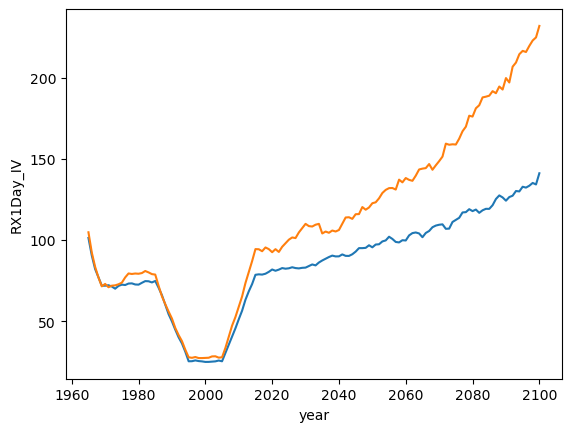

In [87]:
I_raw_A_rx1day_regional.mean(["lat","lon"]).plot()
I_raw_C_rx1day_regional.mean(["lat","lon"]).plot()

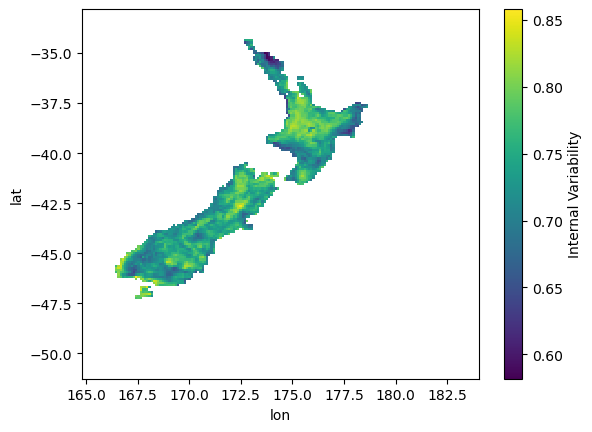

In [41]:
merged_txx['Internal Variability'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot()

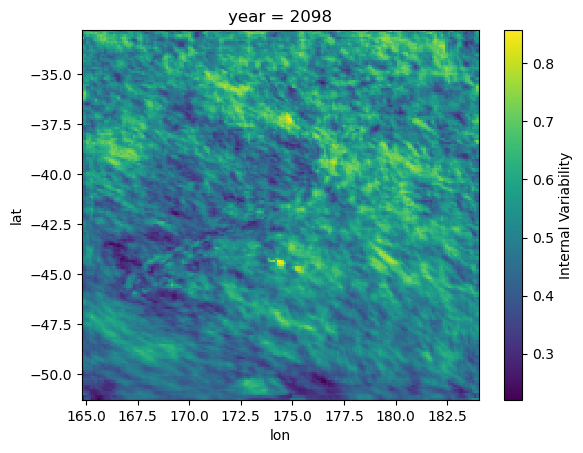

In [42]:
merged_rx1day.isel(year =-3)['Internal Variability'].plot()

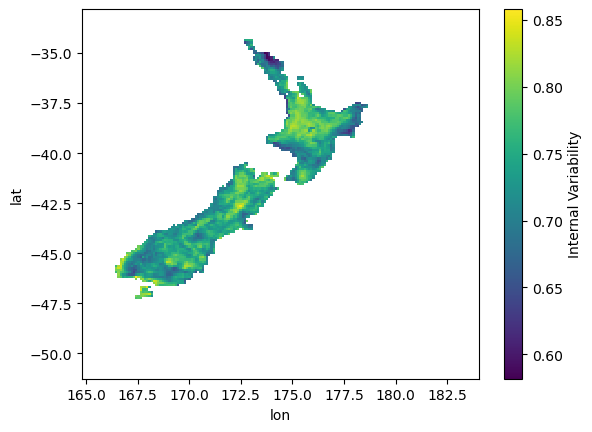

In [43]:
merged_txx['Internal Variability'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot()

Bbox(x0=0.125, y0=0.22263393136017776, x1=0.2693511450381679, y1=0.47247245161854534)


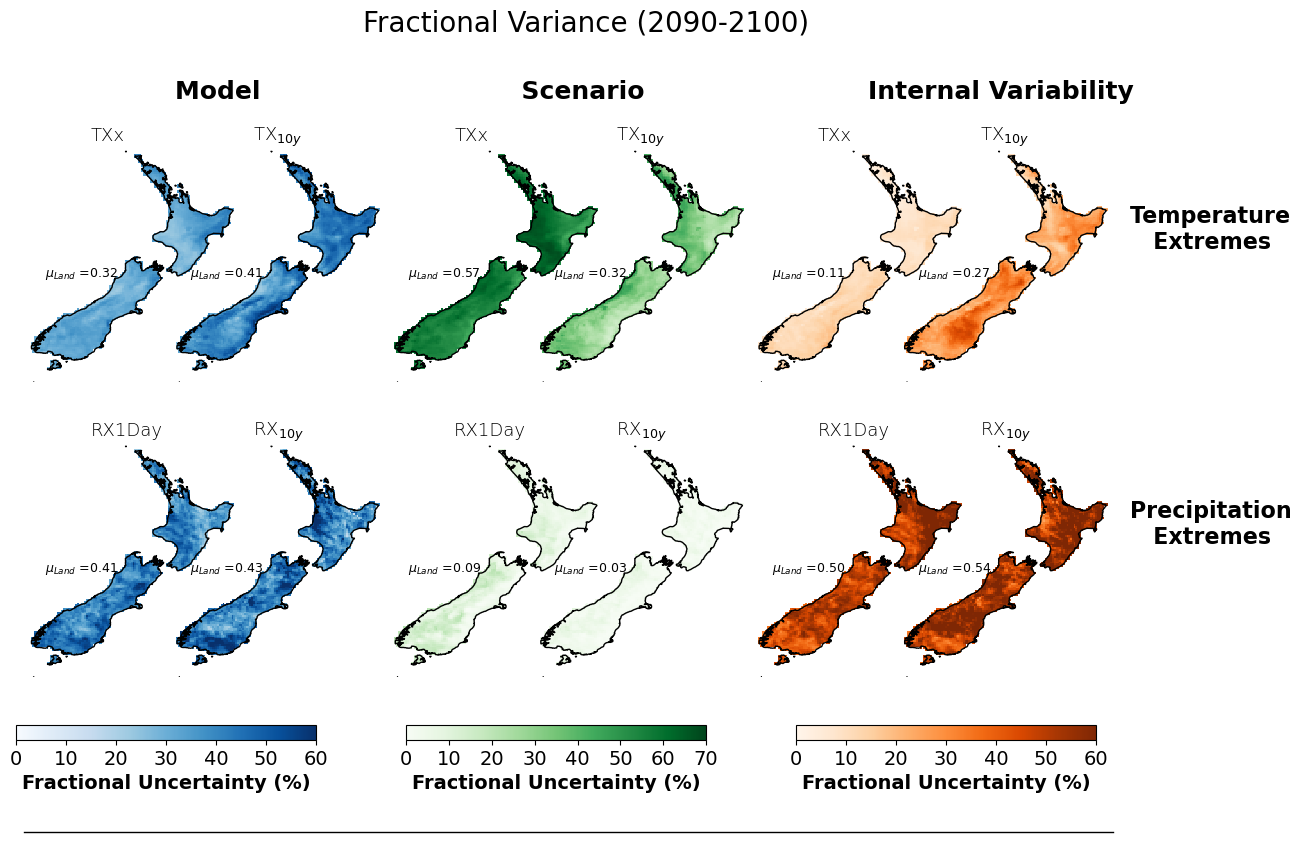

In [73]:


fig = plt.figure(figsize=(15, 10))
#gs1 = gridspec.GridSpec(16, 20, hspace=-35, wspace=0.025)
gs = gridspec.GridSpec(4, 16, hspace=-0.55, wspace=0.025)
ax1 = fig.add_subplot(gs[0:2,0:3], projection=ccrs.PlateCarree(central_longitude =171.77))
ax2 = fig.add_subplot(gs[0:2,2:5], projection=ccrs.PlateCarree(central_longitude =171.77))
ax3 = fig.add_subplot(gs[0:2,5:8], projection=ccrs.PlateCarree(central_longitude =171.77))
ax4 = fig.add_subplot(gs[0:2,7:10], projection=ccrs.PlateCarree(central_longitude =171.77))
ax5 = fig.add_subplot(gs[0:2,10:13], projection=ccrs.PlateCarree(central_longitude =171.77))
ax6 = fig.add_subplot(gs[0:2,12:15], projection=ccrs.PlateCarree(central_longitude =171.77))


ax11 = fig.add_subplot(gs[2:4,0:3], projection=ccrs.PlateCarree(central_longitude =171.77))
ax22 = fig.add_subplot(gs[2:4,2:5], projection=ccrs.PlateCarree(central_longitude =171.77))
ax33 = fig.add_subplot(gs[2:4,5:8], projection=ccrs.PlateCarree(central_longitude =171.77))
ax44 = fig.add_subplot(gs[2:4,7:10], projection=ccrs.PlateCarree(central_longitude =171.77))
ax55 = fig.add_subplot(gs[2:4,10:13], projection=ccrs.PlateCarree(central_longitude =171.77))
ax66 = fig.add_subplot(gs[2:4,12:15], projection=ccrs.PlateCarree(central_longitude =171.77))


v_max_s =0.7
v_max_I = 0.6
v_max_m = 0.6


axes = [ax11, ax22, ax33, ax44, ax55, ax66, ax1, ax2, ax3, ax4, 
        ax5, ax6]

def plot_with_mean(ax, data_array, cmap, vmin, vmax):
    im = data_array.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree(), add_colorbar=False)
    mean_val = data_array.mean().item()
    ax.text(167.25, -41, '$\mu_{Land}$' +f' ={mean_val:.2f}', transform=ccrs.PlateCarree(),
            fontsize=9, verticalalignment='top', color='black')
    return im

# === RX1DAY: 2090–2100 ===
plot_with_mean(ax11, merged_rx1day['Model'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax33, merged_rx1day['Scenario'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax55, merged_rx1day['Internal Variability'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)

# === RX10: 2090–2100 ===
plot_with_mean(ax22, merged_rx10['Model'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax44, merged_rx10['Scenario'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax66, merged_rx10['Internal Variability'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)



# === TXx: 2090–2100 ===
plot_with_mean(ax1, merged_txx['Model'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax3, merged_txx['Scenario'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax5, merged_txx['Internal Variability'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)

# === TX10: 2090–2100 ===
cs1 = plot_with_mean(ax2, merged_tx10['Model'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
cs2 = plot_with_mean(ax4, merged_tx10['Scenario'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
cs3 =plot_with_mean(ax6, merged_tx10['Internal Variability'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)



[axi.set_extent([166, 179, -48, -33], crs = ccrs.PlateCarree()) for axi in axes]
[axi.set_title(' ') for axi in axes]
[axi.coastlines('10m') for axi in axes]
[axi.set_frame_on(False) for axi in axes]
ax1.text(173, -31, '    Model', fontsize =18, weight='bold', transform = ccrs.PlateCarree())
ax3.text(173, -31, '  Scenario', fontsize =18, weight='bold', transform = ccrs.PlateCarree())
ax5.text(173, -31, 'Internal Variability', fontsize =18, weight='bold', transform = ccrs.PlateCarree())
ax14 = fig.add_axes([0.12, 0.16, 0.2, 0.015])
cbar = fig.colorbar(cs1, cax = ax14, orientation ='horizontal')
cbar.set_label('Fractional Uncertainty (%)', fontsize =14, weight ='bold')
ax15 = fig.add_axes([0.38, 0.16, 0.2, 0.015])
cbar2 = fig.colorbar(cs2, cax = ax15, orientation ='horizontal')
cbar2.set_label('Fractional Uncertainty (%)', fontsize =14, weight ='bold')

ax16 = fig.add_axes([0.64, 0.16, 0.2, 0.015])
cbar3 = fig.colorbar(cs3, cax = ax16, orientation ='horizontal')
cbar3.set_label('Fractional Uncertainty (%)', fontsize =14,  weight ='bold')
cbar.set_ticks(np.arange(0, v_max_m+0.1, 0.1))
cbar.set_ticklabels(["%.0f" % f for f in np.arange(0, v_max_m+0.1, 0.1)*100])
cbar2.set_ticks(np.arange(0, v_max_s+0.1, 0.1))
cbar2.set_ticklabels(["%.0f" % f for f in np.arange(0, v_max_s+0.1, 0.1)*100])

cbar3.set_ticks(np.arange(0, v_max_I+0.1, 0.1))
cbar3.set_ticklabels(["%.0f" % f for f in np.arange(0, v_max_I+0.1, 0.1)*100])
cbar3.ax.tick_params(labelsize =14)
cbar2.ax.tick_params(labelsize =14)
cbar.ax.tick_params(labelsize =14)

# Add text label ("JJA") on the left
#fig.text(0.08, 0.48 + (0.85 - 0.5)/2, '  Last Decade \n (2090 - 2100)', fontsize=20, va='center', ha='center', weight ='bold', rotation =90)

# Add thick bracket-like symbol
# bracket_x = [0.05, 0.03, 0.03, 0.05]  # X-coordinates
# bracket_y = [0.8, 0.8, 0.5, 0.5]  # Y-coordinates
# ax51 = fig.add_axes([0, 0.52, 0.05, 0.4])#

# ax51.plot(bracket_x, bracket_y, transform=fig.transFigure, lw=5, color='black', clip_on=False)
# ax51.set_frame_on(False)
# ax51.set_xticks([])
# ax51.set_yticks([])
# fig.text(0.08, 0.15 + (0.4 - 0.05)/2, '  Last Decade \n (2090 - 2099)', fontsize=20, va='center', ha='center', weight ='bold', rotation =90)
# #fig.text(-0.078, -0.05 +  (0.4 - 0.05)/2, "Forced\n$RMS_{GCM-GAN}$=" + f'{"%.1f" % np.sqrt(abs(cc_signal.where(static_fields.orog>0, np.nan).mean("GCM_variant") - cc_signal_em.where(static_fields.orog>0, np.nan).mean("GCM_variant"))**2).mean()}', fontsize=15, va='center', ha='center', rotation =0)
# # Add thick bracket-like symbol
# bracket_x = [0.05, 0.03, 0.03, 0.05]  # X-coordinates
# bracket_y = [0.47, 0.47, 0.17, 0.17]  # Y-coordinates
# ax61 = fig.add_axes([0, 0.05, 0.05, 0.4])

# ax61.plot(bracket_x, bracket_y, transform=fig.transFigure, lw=5, color='black', clip_on=False)
# ax61.set_frame_on(False)
# ax61.set_xticks([])
# ax61.set_yticks([])
#ax1.text(160, -41, '  First Decade \n (2015 - 2024)', fontsize =16,  transform = ccrs.PlateCarree())
#ax11.text(160, -41, '  Last Decade \n (2090 - 2099)', fontsize =16, transform = ccrs.PlateCarree())
ax11.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax22.text(171, -33.5, 'RX$_{10y}$', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

ax33.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax44.text(171, -33.5, 'RX$_{10y}$', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax55.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax66.text(171, -33.5, 'RX$_{10y}$', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)


# ax111.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
# ax222.text(171, -33.5, 'RX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

# ax333.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
# ax444.text(171, -33.5, 'RX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
# ax555.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
# ax666.text(171, -33.5, 'RX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)


ax1.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax2.text(171, -33.5, 'TX$_{10y}$', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

ax3.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax4.text(171, -33.5, 'TX$_{10y}$', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax5.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax6.text(171, -33.5, 'TX$_{10y}$', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

#ax1111.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
#ax2222.text(171, -33.5, 'TX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

# ax3333.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
# ax4444.text(171, -33.5, 'TX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
# ax5555.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
# ax6666.text(171, -33.5, 'TX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax66.text(180, -40, 'Precipitation \n   Extremes' , fontsize =16, transform = ccrs.PlateCarree(), weight ='bold')
#ax666.text(180, -40, 'Precipitation \n   Extremes' , fontsize =16, transform = ccrs.PlateCarree(), weight ='bold')
#ax6666.text(180, -40, 'Temperature \n   Extremes' , fontsize =16, transform = ccrs.PlateCarree(), weight ='bold')
ax6.text(180, -40, 'Temperature \n   Extremes' , fontsize =16, transform = ccrs.PlateCarree(), weight ='bold')


from matplotlib.lines import Line2D
bbox = ax11.get_position()
bbox1 = ax6.get_position()
print(bbox)  # This gives (x0, y0, x1, y1)

# Then place the line slightly below y0
y_line = bbox.y0 - 0.155  # Slightly below ax1

# Draw the line
fig.add_artist(Line2D(
    [bbox.x0, bbox1.x1],
    [y_line, y_line],
    color='black',
    linewidth=1
))

fig.suptitle('Fractional Variance (2090-2100)', fontsize=20, x =0.5, y =0.89)
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Hawkins_Sutton/Final_figure5_vtop_v170625.png', dpi =500, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Hawkins_Sutton/Final_figure5_vtop_v2.pdf', dpi =100, bbox_inches ='tight')

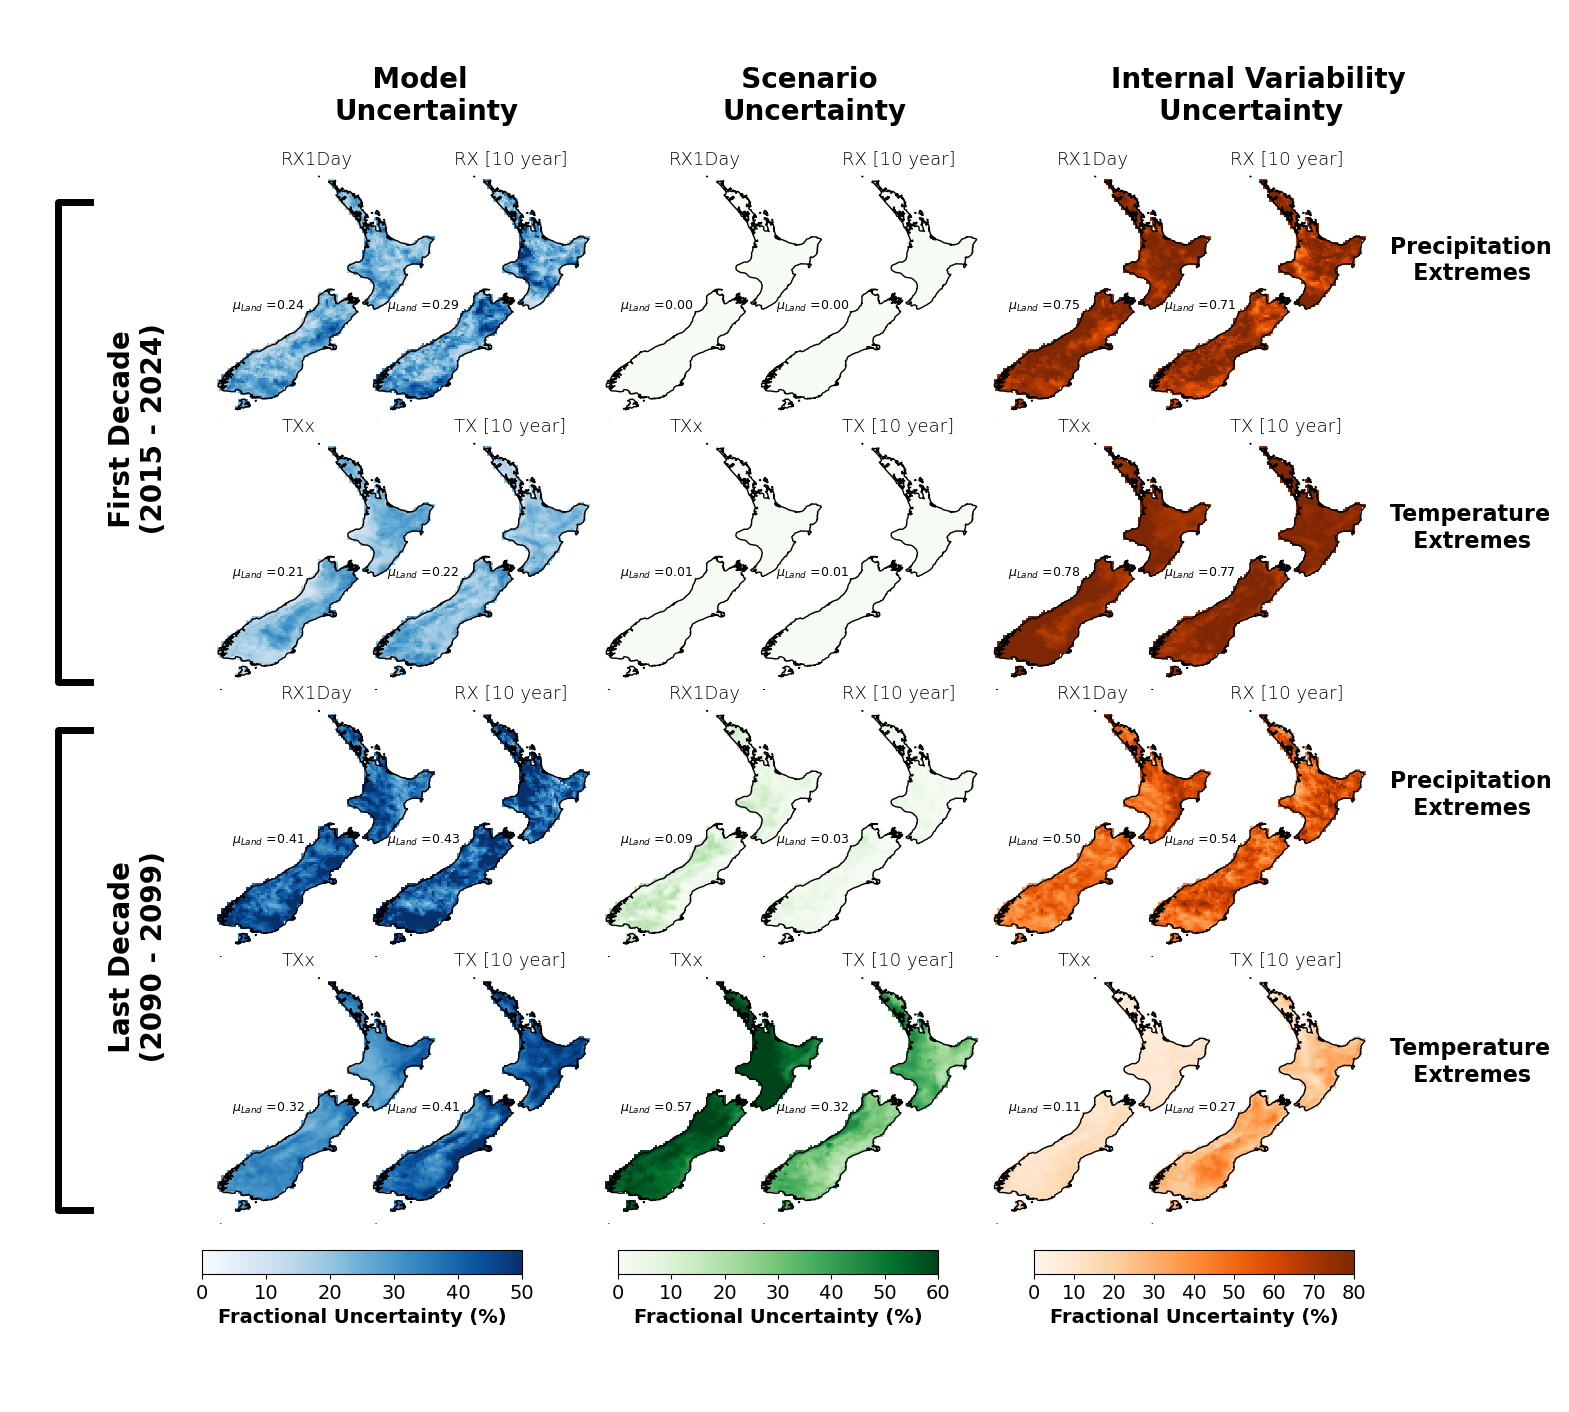

In [93]:


fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(8, 16, hspace=-0.55, wspace=0.025)
ax1 = fig.add_subplot(gs[0:2,0:3], projection=ccrs.PlateCarree(central_longitude =171.77))
ax2 = fig.add_subplot(gs[0:2,2:5], projection=ccrs.PlateCarree(central_longitude =171.77))
ax3 = fig.add_subplot(gs[0:2,5:8], projection=ccrs.PlateCarree(central_longitude =171.77))
ax4 = fig.add_subplot(gs[0:2,7:10], projection=ccrs.PlateCarree(central_longitude =171.77))
ax5 = fig.add_subplot(gs[0:2,10:13], projection=ccrs.PlateCarree(central_longitude =171.77))
ax6 = fig.add_subplot(gs[0:2,12:15], projection=ccrs.PlateCarree(central_longitude =171.77))


ax11 = fig.add_subplot(gs[2:4,0:3], projection=ccrs.PlateCarree(central_longitude =171.77))
ax22 = fig.add_subplot(gs[2:4,2:5], projection=ccrs.PlateCarree(central_longitude =171.77))
ax33 = fig.add_subplot(gs[2:4,5:8], projection=ccrs.PlateCarree(central_longitude =171.77))
ax44 = fig.add_subplot(gs[2:4,7:10], projection=ccrs.PlateCarree(central_longitude =171.77))
ax55 = fig.add_subplot(gs[2:4,10:13], projection=ccrs.PlateCarree(central_longitude =171.77))
ax66 = fig.add_subplot(gs[2:4,12:15], projection=ccrs.PlateCarree(central_longitude =171.77))








ax111 = fig.add_subplot(gs[4:6,0:3], projection=ccrs.PlateCarree(central_longitude =171.77))
ax222 = fig.add_subplot(gs[4:6,2:5], projection=ccrs.PlateCarree(central_longitude =171.77))
ax333 = fig.add_subplot(gs[4:6,5:8], projection=ccrs.PlateCarree(central_longitude =171.77))
ax444 = fig.add_subplot(gs[4:6,7:10], projection=ccrs.PlateCarree(central_longitude =171.77))
ax555 = fig.add_subplot(gs[4:6,10:13], projection=ccrs.PlateCarree(central_longitude =171.77))
ax666 = fig.add_subplot(gs[4:6,12:15], projection=ccrs.PlateCarree(central_longitude =171.77))


ax1111 = fig.add_subplot(gs[6:8,0:3], projection=ccrs.PlateCarree(central_longitude =171.77))
ax2222 = fig.add_subplot(gs[6:8,2:5], projection=ccrs.PlateCarree(central_longitude =171.77))
ax3333 = fig.add_subplot(gs[6:8,5:8], projection=ccrs.PlateCarree(central_longitude =171.77))
ax4444 = fig.add_subplot(gs[6:8,7:10], projection=ccrs.PlateCarree(central_longitude =171.77))
ax5555 = fig.add_subplot(gs[6:8,10:13], projection=ccrs.PlateCarree(central_longitude =171.77))
ax6666 = fig.add_subplot(gs[6:8,12:15], projection=ccrs.PlateCarree(central_longitude =171.77))

v_max_s =0.6
v_max_I = 0.8
v_max_m = 0.5


axes = [ax11, ax22, ax33, ax44, ax55, ax66, ax1, ax2, ax3, ax4, 
        ax5, ax6, ax111, ax222, ax333, ax444, ax555, ax666, ax1111, ax2222, ax3333, ax4444, ax5555, ax6666]

def plot_with_mean(ax, data_array, cmap, vmin, vmax):
    im = data_array.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree(), add_colorbar=False)
    mean_val = data_array.mean().item()
    ax.text(167.25, -41, '$\mu_{Land}$' +f' ={mean_val:.2f}', transform=ccrs.PlateCarree(),
            fontsize=9, verticalalignment='top', color='black')
    return im

# === RX1DAY: 2090–2100 ===
plot_with_mean(ax111, merged_rx1day['Model'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax333, merged_rx1day['Scenario'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax555, merged_rx1day['Internal Variability'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)

# === RX10: 2090–2100 ===
plot_with_mean(ax222, merged_rx10['Model'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax444, merged_rx10['Scenario'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax666, merged_rx10['Internal Variability'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)

# === RX1DAY: 2015–2025 ===
cs1 = plot_with_mean(ax1, merged_rx1day['Model'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
cs2 = plot_with_mean(ax3, merged_rx1day['Scenario'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
cs3 = plot_with_mean(ax5, merged_rx1day['Internal Variability'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)

# === RX10: 2015–2025 ===
plot_with_mean(ax2, merged_rx10['Model'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax4, merged_rx10['Scenario'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax6, merged_rx10['Internal Variability'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)

# === TXx: 2090–2100 ===
plot_with_mean(ax1111, merged_txx['Model'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax3333, merged_txx['Scenario'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax5555, merged_txx['Internal Variability'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)

# === TX10: 2090–2100 ===
plot_with_mean(ax2222, merged_tx10['Model'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax4444, merged_tx10['Scenario'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax6666, merged_tx10['Internal Variability'].sel(year=slice(2090, 2100)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)

# === TXx: 2015–2025 ===
plot_with_mean(ax11, merged_txx['Model'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax33, merged_txx['Scenario'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax55, merged_txx['Internal Variability'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)

# === TX10: 2015–2025 ===
plot_with_mean(ax22, merged_tx10['Model'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Blues', vmin=0, vmax=v_max_m)
plot_with_mean(ax44, merged_tx10['Scenario'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Greens', vmin=0, vmax=v_max_s)
plot_with_mean(ax66, merged_tx10['Internal Variability'].sel(year=slice(2015, 2025)).mean("year").where(static_fields.orog > 0, np.nan),
               cmap='Oranges', vmin=0, vmax=v_max_I)
#fig, ax = plt.subplots(2,3, figsize = (18, 10), subplot_kw = dict(projection =ccrs.PlateCarree(central_longitude =171.77)), sharex=True, sharey =True)
# cs1 = merged_rx1day['Model'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax111, cmap ='Blues', vmin =0, vmax =v_max_m, transform = ccrs.PlateCarree(), add_colorbar =False)
# cs2 = merged_rx1day['Scenario'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax333, cmap ='Greens', vmin =0, vmax =v_max_s, transform = ccrs.PlateCarree(), add_colorbar =False)
# cs3 = merged_rx1day['Internal Variability'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax555, cmap ='Oranges', vmin =0, vmax =v_max_I, transform = ccrs.PlateCarree(), add_colorbar =False)


# merged_rx10['Model'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax222, cmap ='Blues', vmin =0, vmax =v_max_m, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_rx10['Scenario'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax444, cmap ='Greens', vmin =0, vmax =v_max_s, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_rx10['Internal Variability'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax666, cmap ='Oranges', vmin =0, vmax =v_max_I, transform = ccrs.PlateCarree(), add_colorbar =False)


# merged_rx1day['Model'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax1, cmap ='Blues', vmin =0, vmax =v_max_m, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_rx1day['Scenario'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax3, cmap ='Greens', vmin =0, vmax =v_max_s, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_rx1day['Internal Variability'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax5, cmap ='Oranges', vmin =0, vmax =v_max_I, transform = ccrs.PlateCarree(), add_colorbar =False)


# merged_rx10['Model'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax2, cmap ='Blues', vmin =0, vmax =v_max_m, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_rx10['Scenario'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax4, cmap ='Greens', vmin =0, vmax =v_max_s, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_rx10['Internal Variability'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax6, cmap ='Oranges', vmin =0, vmax =v_max_I, transform = ccrs.PlateCarree(), add_colorbar =False)



# merged_txx['Model'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax1111, cmap ='Blues', vmin =0, vmax =v_max_m, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_txx['Scenario'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax3333, cmap ='Greens', vmin =0, vmax =v_max_s, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_txx['Internal Variability'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax5555, cmap ='Oranges', vmin =0, vmax =v_max_I, transform = ccrs.PlateCarree(), add_colorbar =False)


# merged_tx10['Model'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax2222, cmap ='Blues', vmin =0, vmax =v_max_m, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_tx10['Scenario'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax4444, cmap ='Greens', vmin =0, vmax =v_max_s, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_tx10['Internal Variability'].sel(year =slice(2090,2100)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax6666, cmap ='Oranges', vmin =0, vmax =v_max_I, transform = ccrs.PlateCarree(), add_colorbar =False)


# merged_txx['Model'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax11, cmap ='Blues', vmin =0, vmax =v_max_m, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_txx['Scenario'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax33, cmap ='Greens', vmin =0, vmax =v_max_s, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_txx['Internal Variability'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax55, cmap ='Oranges', vmin =0, vmax =v_max_I, transform = ccrs.PlateCarree(), add_colorbar =False)


# merged_tx10['Model'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax22, cmap ='Blues', vmin =0, vmax =v_max_m, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_tx10['Scenario'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax44, cmap ='Greens', vmin =0, vmax =v_max_s, transform = ccrs.PlateCarree(), add_colorbar =False)
# merged_tx10['Internal Variability'].sel(year =slice(2015,2025)).mean("year").where(static_fields.orog>0, np.nan).plot(ax =ax66, cmap ='Oranges', vmin =0, vmax =v_max_I, transform = ccrs.PlateCarree(), add_colorbar =False)
# ax[0,0].set_title('Model Uncertainty', weight ='bold', fontsize =15)
# ax[0,1].set_title('Scenario Uncertainty', weight ='bold', fontsize =15)
# ax[0,2].set_title('Internal Variability Uncertainty', weight ='bold', fontsize =15)
# ax[1,0].set_title(' ')
# ax[1,1].set_title(' ')
# ax[1,2].set_title(' ')
# ax[0,0].coastlines('10m')
# ax[0,1].coastlines('10m')
# ax[0,2].coastlines('10m')
# ax[1,0].coastlines('10m')
# ax[1,1].coastlines('10m')
# ax[1,2].coastlines('10m')
[axi.set_extent([166, 179, -48, -33], crs = ccrs.PlateCarree()) for axi in axes]
[axi.set_title(' ') for axi in axes]
[axi.coastlines('10m') for axi in axes]
[axi.set_frame_on(False) for axi in axes]
ax1.text(173, -31, '    Model \nUncertainty', fontsize =20, weight='bold', transform = ccrs.PlateCarree())
ax3.text(173, -31, '  Scenario \nUncertainty', fontsize =20, weight='bold', transform = ccrs.PlateCarree())
ax5.text(173, -31, 'Internal Variability\n     Uncertainty', fontsize =20, weight='bold', transform = ccrs.PlateCarree())
ax14 = fig.add_axes([0.12, 0.13, 0.2, 0.015])
cbar = fig.colorbar(cs1, cax = ax14, orientation ='horizontal')
cbar.set_label('Fractional Uncertainty (%)', fontsize =14, weight ='bold')
ax15 = fig.add_axes([0.38, 0.13, 0.2, 0.015])
cbar2 = fig.colorbar(cs2, cax = ax15, orientation ='horizontal')
cbar2.set_label('Fractional Uncertainty (%)', fontsize =14, weight ='bold')

ax16 = fig.add_axes([0.64, 0.13, 0.2, 0.015])
cbar3 = fig.colorbar(cs3, cax = ax16, orientation ='horizontal')
cbar3.set_label('Fractional Uncertainty (%)', fontsize =14,  weight ='bold')
cbar.set_ticks(np.arange(0, v_max_m+0.1, 0.1))
cbar.set_ticklabels(["%.0f" % f for f in np.arange(0, v_max_m+0.1, 0.1)*100])
cbar2.set_ticks(np.arange(0, v_max_s+0.1, 0.1))
cbar2.set_ticklabels(["%.0f" % f for f in np.arange(0, v_max_s+0.1, 0.1)*100])

cbar3.set_ticks(np.arange(0, v_max_I+0.1, 0.1))
cbar3.set_ticklabels(["%.0f" % f for f in np.arange(0, v_max_I+0.1, 0.1)*100])
cbar3.ax.tick_params(labelsize =14)
cbar2.ax.tick_params(labelsize =14)
cbar.ax.tick_params(labelsize =14)

# Add text label ("JJA") on the left
fig.text(0.08, 0.48 + (0.85 - 0.5)/2, '  First Decade \n (2015 - 2024)', fontsize=20, va='center', ha='center', weight ='bold', rotation =90)

# Add thick bracket-like symbol
bracket_x = [0.05, 0.03, 0.03, 0.05]  # X-coordinates
bracket_y = [0.8, 0.8, 0.5, 0.5]  # Y-coordinates
ax51 = fig.add_axes([0, 0.52, 0.05, 0.4])#

ax51.plot(bracket_x, bracket_y, transform=fig.transFigure, lw=5, color='black', clip_on=False)
ax51.set_frame_on(False)
ax51.set_xticks([])
ax51.set_yticks([])
fig.text(0.08, 0.15 + (0.4 - 0.05)/2, '  Last Decade \n (2090 - 2099)', fontsize=20, va='center', ha='center', weight ='bold', rotation =90)
#fig.text(-0.078, -0.05 +  (0.4 - 0.05)/2, "Forced\n$RMS_{GCM-GAN}$=" + f'{"%.1f" % np.sqrt(abs(cc_signal.where(static_fields.orog>0, np.nan).mean("GCM_variant") - cc_signal_em.where(static_fields.orog>0, np.nan).mean("GCM_variant"))**2).mean()}', fontsize=15, va='center', ha='center', rotation =0)
# Add thick bracket-like symbol
bracket_x = [0.05, 0.03, 0.03, 0.05]  # X-coordinates
bracket_y = [0.47, 0.47, 0.17, 0.17]  # Y-coordinates
ax61 = fig.add_axes([0, 0.05, 0.05, 0.4])

ax61.plot(bracket_x, bracket_y, transform=fig.transFigure, lw=5, color='black', clip_on=False)
ax61.set_frame_on(False)
ax61.set_xticks([])
ax61.set_yticks([])
#ax1.text(160, -41, '  First Decade \n (2015 - 2024)', fontsize =16,  transform = ccrs.PlateCarree())
#ax11.text(160, -41, '  Last Decade \n (2090 - 2099)', fontsize =16, transform = ccrs.PlateCarree())
ax1.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax2.text(171, -33.5, 'RX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

ax3.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax4.text(171, -33.5, 'RX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax5.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax6.text(171, -33.5, 'RX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)


ax111.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax222.text(171, -33.5, 'RX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

ax333.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax444.text(171, -33.5, 'RX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax555.text(170, -33.5, 'RX1Day', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax666.text(171, -33.5, 'RX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)


ax11.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax22.text(171, -33.5, 'TX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

ax33.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax44.text(171, -33.5, 'TX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax55.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax66.text(171, -33.5, 'TX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

ax1111.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax2222.text(171, -33.5, 'TX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)

ax3333.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax4444.text(171, -33.5, 'TX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax5555.text(170, -33.5, 'TXx', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax6666.text(171, -33.5, 'TX [10 year]', fontsize =13, transform = ccrs.PlateCarree(), weight ='light',)
ax6.text(180, -40, 'Precipitation \n   Extremes' , fontsize =16, transform = ccrs.PlateCarree(), weight ='bold')
ax666.text(180, -40, 'Precipitation \n   Extremes' , fontsize =16, transform = ccrs.PlateCarree(), weight ='bold')
ax6666.text(180, -40, 'Temperature \n   Extremes' , fontsize =16, transform = ccrs.PlateCarree(), weight ='bold')
ax66.text(180, -40, 'Temperature \n   Extremes' , fontsize =16, transform = ccrs.PlateCarree(), weight ='bold')
#fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/internal_variability_uncertainty_spatial_rx1day_txx_static_I_v040525.png', dpi =500, bbox_inches ='tight')
#fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/internal_variability_uncertainty_spatial_rx1day_txx_static_I_v040525.pdf', dpi =300, bbox_inches ='tight')
# ax[0,0].text(165, -43, '2015 - 2025', weight ='bold', transform = ccrs.PlateCarree(), fontsize = 18, rotation =90)
# ax[1,0].text(165, -43, '2090 - 2100', weight ='bold', transform = ccrs.PlateCarree(), fontsize = 18, rotation =90)
# [ax[i,j].set_frame_on(False) for i in range(2) for j in range(3)]
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Hawkins_Sutton/Figure_4_Spatial_Hawkins_andSutton_v170625.png', dpi =500, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Hawkins_Sutton/Figure_4_Spatial_Hawkins_andSutton_v170625.pdf', dpi =100, bbox_inches ='tight')

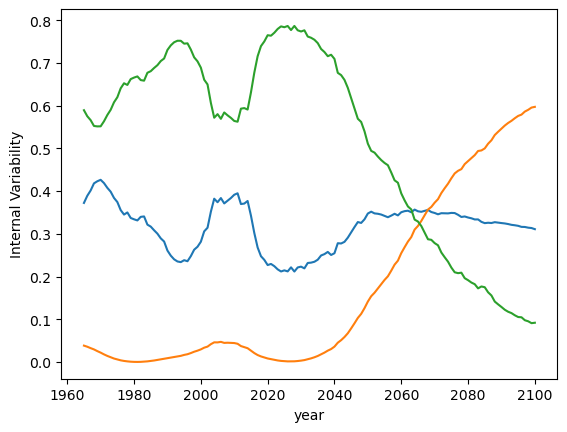

In [47]:
merged_txx['Model'].where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot()
merged_txx['Scenario'].where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot()
merged_txx['Internal Variability'].where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot()

In [48]:
merged_rx10

<xarray.Dataset>
Dimensions:               (year: 131, lat: 172, lon: 179)
Coordinates:
  * year                  (year) int64 1970 1971 1972 1973 ... 2098 2099 2100
  * lat                   (lat) float64 -51.21 -51.11 -51.0 ... -32.97 -32.86
  * lon                   (lon) float64 164.9 165.0 165.1 ... 183.7 183.9 184.0
Data variables:
    Scenario              (year, lat, lon) float64 0.0005806 ... 0.0944
    Internal Variability  (year, lat, lon) float64 0.3139 0.3227 ... 0.5745
    Model                 (year, lat, lon) float64 0.6855 0.6767 ... 0.3311
    Total                 (year, lat, lon) float64 145.3 112.6 ... 1.343e+04
    Static I              (lat, lon) float64 54.18 44.77 ... 1.277e+03 1.898e+03

In [49]:
((merged_txx['Internal Variability'] * merged_txx['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"])

<xarray.DataArray (year: 136)>
array([0.3888258 , 0.34484321, 0.31701356, 0.28212349, 0.26631772,
       0.25411543, 0.25388976, 0.25715939, 0.25733443, 0.2618443 ,
       0.2598781 , 0.27506175, 0.2754076 , 0.26262598, 0.26965103,
       0.25814785, 0.25336389, 0.23380606, 0.22499485, 0.23773118,
       0.23185583, 0.23037377, 0.2327823 , 0.23957194, 0.23581215,
       0.25475169, 0.2587955 , 0.26138674, 0.25971288, 0.25390907,
       0.24364431, 0.2407422 , 0.21849525, 0.19490154, 0.18304551,
       0.16825898, 0.14352076, 0.13351393, 0.10648715, 0.09094402,
       0.09239763, 0.08725031, 0.09202368, 0.08907239, 0.08669898,
       0.08457877, 0.08460298, 0.09335408, 0.09287816, 0.09094402,
       0.10859197, 0.13242945, 0.16070318, 0.18293811, 0.19455733,
       0.21030396, 0.2103448 , 0.22548332, 0.24090771, 0.25427957,
       0.25580655, 0.27762125, 0.26542229, 0.2875365 , 0.27718905,
       0.28591914, 0.30526479, 0.28775476, 0.30377125, 0.31108154,
       0.30926196, 0.30287565, 0.29889337, 0.29456741, 0.31275113,
       0.31161268, 0.28198012, 0.29135204, 0.29079798, 0.28369709,
       0.26832547, 0.25831872, 0.24732774, 0.25610481, 0.25021543,
       0.23710357, 0.23322921, 0.23981933, 0.24695982, 0.2532896 ,
       0.25919323, 0.26668625, 0.26208099, 0.2573644 , 0.26713874,
       0.25551707, 0.2524639 , 0.25324635, 0.26086524, 0.24885954,
       0.25908482, 0.25989938, 0.2529699 , 0.24626469, 0.25732038,
       0.26122983, 0.26867185, 0.2591064 , 0.25827848, 0.25515719,
       0.24726901, 0.24389812, 0.2533107 , 0.26914017, 0.2604551 ,
       0.265016  , 0.26928393, 0.27520909, 0.26831627, 0.28942405,
       0.30046966, 0.2880792 , 0.28509064, 0.26516337, 0.26182728,
       0.26026271, 0.25682217, 0.25583018, 0.25854172, 0.25563486,
       0.25447656, 0.26434546, 0.2543455 , 0.25778257, 0.25520986,
       0.26805315])
Coordinates:
  * year     (year) int64 1965 1966 1967 1968 1969 ... 2096 2097 2098 2099 2100

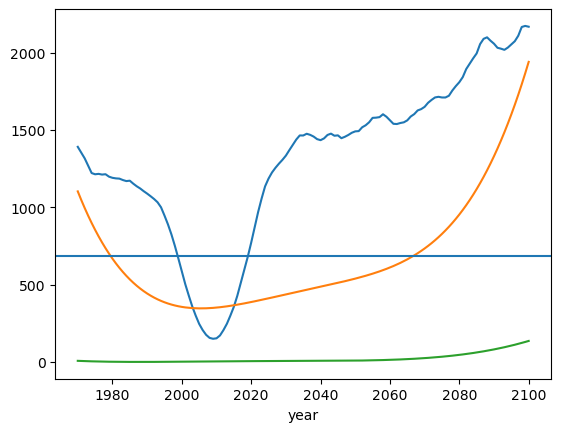

In [50]:
((merged_rx10['Internal Variability'] * merged_rx10['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot()
((merged_rx10['Model'] * merged_rx10['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot()
((merged_rx10['Scenario'] * merged_rx10['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot()
plt.axhline(((merged_rx10['Static I'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]))
#merged_rx10['Scenario'].where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot()
#merged_rx10['Internal Variability'].where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(color ='r')

In [51]:
merged_txx['Internal Variability']

<xarray.DataArray 'Internal Variability' (year: 136, lat: 172, lon: 179)>
array([[[0.57552832, 0.55785115, 0.55786636, ..., 0.63558191,
         0.64463578, 0.65674484],
        [0.55634991, 0.54078883, 0.54871413, ..., 0.61490293,
         0.62183877, 0.63143081],
        [0.54784168, 0.53924521, 0.54500145, ..., 0.62311774,
         0.61471598, 0.62261998],
        ...,
        [0.53916791, 0.54674026, 0.54812677, ..., 0.58554308,
         0.58923193, 0.6007913 ],
        [0.5450082 , 0.54847184, 0.54390788, ..., 0.57163745,
         0.58531046, 0.59469105],
        [0.56119964, 0.55937916, 0.55429379, ..., 0.56088346,
         0.57609121, 0.58496488]],

       [[0.55644996, 0.54022866, 0.54190438, ..., 0.63666927,
         0.64618413, 0.65760517],
        [0.53230173, 0.51903246, 0.52717777, ..., 0.61374745,
         0.62099281, 0.62982339],
        [0.52246672, 0.51519145, 0.51967932, ..., 0.61872728,
         0.60965003, 0.61777254],
...
        [0.03939457, 0.03756344, 0.03521241, ..., 0.03883568,
         0.03825833, 0.03863722],
        [0.03954349, 0.03818951, 0.03682528, ..., 0.03859175,
         0.03772092, 0.038256  ],
        [0.03955158, 0.03847464, 0.03785027, ..., 0.03854399,
         0.03802129, 0.03880061]],

       [[0.09947763, 0.09838863, 0.09417358, ..., 0.11057028,
         0.11355748, 0.11323576],
        [0.10174901, 0.09945036, 0.0946671 , ..., 0.11628423,
         0.11723847, 0.11775117],
        [0.10527438, 0.1011892 , 0.09601365, ..., 0.11765105,
         0.11890337, 0.11885993],
        ...,
        [0.03203342, 0.03098956, 0.02868516, ..., 0.03587784,
         0.03645311, 0.03688322],
        [0.03281487, 0.03189706, 0.0299303 , ..., 0.03633289,
         0.0363029 , 0.03684797],
        [0.03404327, 0.033118  , 0.03153627, ..., 0.03642822,
         0.03637282, 0.03719595]]])
Coordinates:
  * year     (year) int64 1965 1966 1967 1968 1969 ... 2096 2097 2098 2099 2100
  * lat      (lat) float64 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
  * lon      (lon) float64 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0

rolling av
rolling av
rolling av
Bbox(x0=0.125, y0=0.49465716829919854, x1=0.5745, y1=0.88)
rolling av
rolling av
rolling av
rolling av
rolling av
rolling av
rolling av
rolling av
rolling av


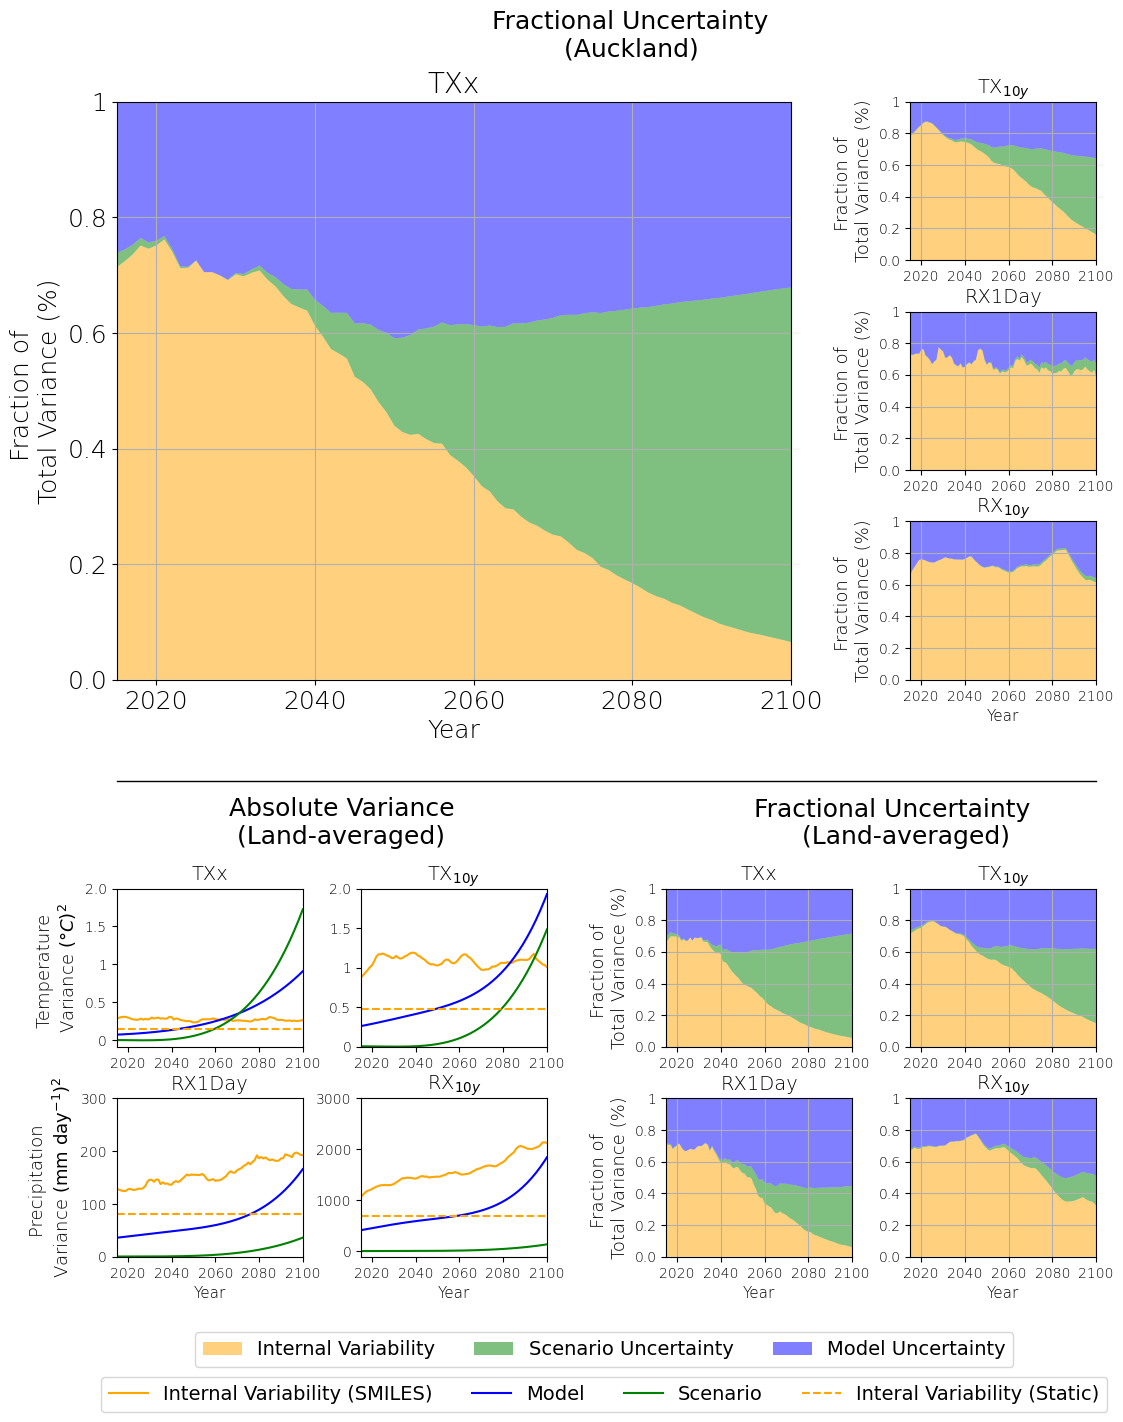

In [92]:
# Set up figure and grid

def plot_fractional_uncertainty(M, S, I, lat, lon, ax = None, region = None):
    if lat is not None:
        M_ = M.interp(lat = lat, lon = lon, method ='nearest')
        S_ = S.interp(lat = lat, lon =lon, method ='nearest')
        
        try:
            print("rolling av")
            I_ = I.interp(lat = lat, lon =lon, method ='nearest').rolling(year =20, min_periods =5).mean()
            #D_ = D.interp(lat = lat, lon =lon, method ='nearest').rolling(year =10, min_periods =1).mean()
        except:
            print("rolling av")
            I_ = I.interp(lat = lat, lon =lon, method ='nearest').rolling(time =20, min_periods =5).mean()
            #D_ = D.interp(lat = lat, lon =lon, method ='nearest').rolling(time =10, min_periods =1).mean()
    else:
        M_ = M
        S_ = S
        #D_ = D
        try:
            print("rolling av")
            I_ = I.rolling(time =20, min_periods =1).mean()
            #D_ = D.rolling(time =10, min_periods =1).mean()
        except:
            print("rolling av")
            I_ = I.rolling(year =20, min_periods =1).mean()
            #D_ = D.rolling(year =10, min_periods =1).mean()
    T = M_ + S_ + I_# + D_
    M_ = M_/T
    S_ = S_/T
    I_ = I_/T
    #D_ = D_/T
    try:
        ax.stackplot(
        I_.year,
        I_,
        S_,
        M_,
        labels=["Internal Variability", "Scenario Uncertainty","Model Uncertainty"],
            colors=["orange", "green", "blue"] , alpha =0.5)
    except:
        ax.stackplot(
        I_.time,
        I_,
        S_,
        M_,
        labels=["Internal Variability", "Scenario Uncertainty","Model Uncertainty"],
            colors=["orange", "green", "blue"] , alpha =0.5)
    #ax_t.set_xlabel("Lead Time [years from 2015]", fontsize=12, fontweight='bold')
    #ax.set_ylabel("Fraction of \nTotal Variance [%]", fontsize=14, fontweight='bold')
    ax.grid('on')
    ax.set_xlim(2015, 2099)
    ax.set_ylim(0,1)
    ax.set_xticks([2020, 2040, 2060, 2080, 2100])
    ax.set_xticklabels([2020, 2040, 2060, 2080, 2100], rotation =0, weight ='light')
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1], rotation =0, weight ='light')
    handles, labels = ax.get_legend_handles_labels()
    return handles, labels    
    #return handles, labels
    

    #ax.set_frame_on(False)
    #ax.text(2035, 1.1, region, fontsize =14, weight ='bold')

fig = plt.figure(figsize=(15 , 15))
gs = GridSpec(23, 20, wspace=20, hspace=50)

ax1 = fig.add_subplot(gs[0:12, 0:12])

ax1.tick_params(labelsize =18)
ax1.set_ylabel("Fraction of \nTotal Variance (%)", fontsize=18, weight ='light')
ax11 = fig.add_subplot(gs[0:4, 13:17])
plot_fractional_uncertainty(merged_txx['Model'], merged_txx['Scenario'], merged_txx['Internal Variability'],
                                 -36.7928, 174.6131, ax = ax1, region = 'Auckland')   

plot_fractional_uncertainty(merged_tx10['Model'], merged_tx10['Scenario'], merged_tx10['Internal Variability'],
                                 -36.7928, 174.6131, ax = ax11, region = 'Auckland')  
ax11.tick_params(labelsize =10)
ax1.set_title('TXx', fontsize =20, weight ='light')
ax11.set_ylabel("Fraction of \nTotal Variance (%)", fontsize=13, weight ='light')
ax111 = fig.add_subplot(gs[4:8, 13:17])
ax1111 = fig.add_subplot(gs[8:12 ,13:17])
plot_fractional_uncertainty(merged_rx1day['Model'], merged_rx1day['Scenario'], merged_rx1day['Internal Variability'],
                                 -36.7928, 174.6131, ax = ax111, region = 'Auckland')  
ax11.set_title('TX$_{10y}$', fontsize =14, weight ='light')


from matplotlib.lines import Line2D
bbox = ax1.get_position()
bbox1 = ax1111.get_position()
print(bbox)  # This gives (x0, y0, x1, y1)

# Then place the line slightly below y0
y_line = bbox.y0 - 0.0675  # Slightly below ax1

# Draw the line
fig.add_artist(Line2D(
    [bbox.x0, bbox1.x1],
    [y_line, y_line],
    color='black',
    linewidth=1
))



max_height = 15
ax111.set_title('RX1Day', fontsize =14, weight ='light')
ax111.tick_params(labelsize =10)
ax111.set_ylabel("Fraction of \nTotal Variance (%)", fontsize=13, weight ='light')

ax1111.tick_params(labelsize =10)
ax1111.set_title('RX$_{10y}$', fontsize= 14, weight ='light')
ax1111.set_ylabel("Fraction of \nTotal Variance (%)", fontsize=13, weight ='light')
plot_fractional_uncertainty(merged_rx10['Model'], merged_rx10['Scenario'], merged_rx10['Internal Variability'],
                                 -43.532, 172.6366, ax = ax1111, region = 'Auckland')  
ax2 = fig.add_subplot(gs[max_height:max_height+4, 0:4])
ax22 = fig.add_subplot(gs[max_height:max_height+4, 4:8])
#plot_fractional_uncertainty(merged_tx10['Model'], merged_tx10['Scenario'], merged_tx10['Internal Variability'],
#                                 -43.532, 172.6366, ax = ax22, region = 'Auckland')  

#plot_fractional_uncertainty(merged_txx['Model'], merged_txx['Scenario'], merged_txx['Internal Variability'],
#                                 -43.532, 172.6366, ax = ax2, region = 'Auckland')  
ax222 = fig.add_subplot(gs[max_height+4:max_height+8, 0:4])
#plot_fractional_uncertainty(merged_rx1day['Model'], merged_rx1day['Scenario'], merged_txx['Internal Variability'],
#                                 -43.532, 172.6366, ax = ax222, region = 'Auckland')  
ax2222 = fig.add_subplot(gs[max_height+4:max_height+8, 4:8])
# plot_fractional_uncertainty(merged_rx10['Model'], merged_rx10['Scenario'], merged_rx10['Internal Variability'],
#                                  -43.532, 172.6366, ax = ax2222, region = 'Auckland')  
# fURTHER SMOOTHING OF RX1Day is required!!!!
# TODO add regional averages here. 
#-43.532, 172.6366

ax3 = fig.add_subplot(gs[max_height:max_height+4, 9:13])
ax33 = fig.add_subplot(gs[max_height:max_height+4, 13:17])
ax333 = fig.add_subplot(gs[max_height+4:max_height+8, 9:13])
ax3333 = fig.add_subplot(gs[max_height+4:max_height+8, 13:17])


plot_fractional_uncertainty(merged_rx10_av['Model'], merged_rx10_av['Scenario'], merged_rx10_av['Internal Variability'],
                                 None, None, ax = ax3333, region = 'Auckland')  

plot_fractional_uncertainty(merged_tx10_av['Model'], merged_tx10_av['Scenario'], merged_tx10_av['Internal Variability'],
                                 None, None, ax = ax33, region = 'Auckland')  

plot_fractional_uncertainty(merged_txx_av['Model'], merged_txx_av['Scenario'], merged_txx_av['Internal Variability'],
                                 None, None, ax = ax3, region = 'Auckland')  

handles, labels = plot_fractional_uncertainty(merged_rx1day_av['Model'], merged_rx1day_av['Scenario'], merged_txx_av['Internal Variability'],
                                 None, None, ax = ax333, region = 'Auckland')  
ax3.set_title('TXx', fontsize =14, weight ='light')
ax3333.set_title('RX$_{10y}$', fontsize =14, weight ='light')
ax33.set_title('TX$_{10y}$', fontsize =14, weight ='light')
ax333.set_title('RX1Day', fontsize =14, weight ='light')
ax1.set_xlabel('Year', fontsize =18, weight ='light')
ax1111.set_xlabel('Year', fontsize =11, weight ='light')
ax2.set_title('TXx', fontsize =14, weight ='light')
ax2222.set_title('RX$_{10y}$', fontsize =14, weight ='light')
ax22.set_title('TX$_{10y}$', fontsize =14, weight ='light')
ax222.set_title('RX1Day', fontsize =14, weight ='light')
ax2.set_ylabel("Fraction of \nTotal Variance (%)", fontsize=13, weight ='light')
ax222.set_ylabel("Fraction of \nTotal Variance (%)", fontsize=13, weight ='light')
ax3.set_ylabel("Fraction of \nTotal Variance (%)", fontsize=13, weight ='light')
ax333.set_ylabel("Fraction of \nTotal Variance (%)", fontsize=13, weight ='light')
fig.text(0.2, 0.385, 'Absolute Variance \n (Land-averaged)', fontsize =18)
fig.text(0.55, 0.385, 'Fractional Uncertainty \n      (Land-averaged)', fontsize =18)
fig.text(0.37, 0.91, ' Fractional Uncertainty  \n          (Auckland)', fontsize =18)

ax222.set_xlabel('Year', fontsize =11, weight ='light')
ax2222.set_xlabel('Year', fontsize =11, weight ='light')

ax333.set_xlabel('Year', fontsize =11, weight ='light')
ax3333.set_xlabel('Year', fontsize =11, weight ='light')



#ax4 = fig.add_subplot(gs[23:27, 0:4])
#ax44 = fig.add_subplot(gs[23:27, 4:8])
#ax444 = fig.add_subplot(gs[23:27, 9:13])
#ax4444 = fig.add_subplot(gs[23:27, 13:17])

((merged_txx['Internal Variability'] * merged_txx['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax2, color ='Orange', label ='Internal Variability (SMILES)')
((merged_txx['Model'] * merged_txx['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax2, color ='Blue', label ='Model' )
((merged_txx['Scenario'] * merged_txx['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax2, color ='Green', label ='Scenario')
ax2.axhline(((merged_txx['Static I'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]), color ='Orange', ls ='--', label ='Interal Variability (Static)')


((merged_tx10['Internal Variability'] * merged_tx10['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax22, color ='Orange')
((merged_tx10['Model'] * merged_tx10['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax22, color ='Blue')
((merged_tx10['Scenario'] * merged_tx10['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax22, color ='Green')
ax22.axhline(((merged_tx10['Static I'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]), color ='Orange', ls ='--')
ax22.set_ylim(0, 2)
ax22.set_ylim(0, 2)








((merged_rx1day['Internal Variability'] * merged_rx1day['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax222, color ='Orange')
((merged_rx1day['Model'] * merged_rx1day['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax222, color ='Blue')
((merged_rx1day['Scenario'] * merged_rx1day['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax222, color ='Green')
ax222.axhline(((merged_rx1day['Static I'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]), color ='Orange', ls ='--')


((merged_rx10['Internal Variability'] * merged_rx10['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax2222, color ='Orange')
((merged_rx10['Model'] * merged_rx10['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax2222, color ='Blue')
((merged_rx10['Scenario'] * merged_rx10['Total'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(ax = ax2222, color ='Green')
ax2222.axhline(((merged_rx10['Static I'])).where(static_fields.orog>0, np.nan).mean(["lat","lon"]), color ='Orange', ls ='--')
#ax4444.set_ylim(0, 2)
#ax444.set_ylim(0, 2)

ax2.set_title('TXx', fontsize= 14, weight ='light')
ax22.set_title('TX$_{10y}$', fontsize= 14, weight ='light')
ax222.set_title('RX1Day', fontsize= 14, weight ='light')
ax2222.set_title('RX$_{10y}$', fontsize= 14, weight ='light')


ax222.set_xlabel('Year', fontsize =11, weight ='light')
ax2222.set_xlabel('Year', fontsize =11, weight ='light')

ax22.set_xlabel(' ', fontsize =11, weight ='light')
ax2.set_xlabel(' ', fontsize =11, weight ='light')

#merged_rx10['Scenario'].where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot()
#merged_rx10['Internal Variability'].where(static_fields.orog>0, np.nan).mean(["lat","lon"]).plot(color ='r')
ax2.set_xticks([2020, 2040, 2060, 2080, 2100], rotation =0, weight ='light')
ax22.set_xticks([2020, 2040, 2060, 2080, 2100], rotation =0, weight ='light')
ax222.set_xticks([2020, 2040, 2060, 2080, 2100], rotation =0, weight ='light')
ax2222.set_xticks([2020, 2040, 2060, 2080, 2100], rotation =0, weight ='light')

ax2.set_xticklabels([2020, 2040, 2060, 2080, 2100], rotation =0, weight ='light')
ax22.set_xticklabels([2020, 2040, 2060, 2080, 2100], rotation =0, weight ='light')
ax222.set_xticklabels([2020, 2040, 2060, 2080, 2100], rotation =0, weight ='light')
ax2222.set_xticklabels([2020, 2040, 2060, 2080, 2100], rotation =0, weight ='light')
ax2222.set_xlim(2015, 2100)
ax222.set_xlim(2015, 2100)

ax22.set_xlim(2015, 2100)
ax2.set_xlim(2015, 2100)


ax2.set_yticks([0, 0.5, 1, 1.5, 2.0], rotation =0, weight ='light')
ax22.set_yticks([0, 0.5, 1, 1.5, 2.0], rotation =0, weight ='light')
ax222.set_yticks([0,100, 200, 300, 400], rotation =0, weight ='light')
ax2222.set_yticks([0, 1000, 2000, 3000], rotation =0, weight ='light')

ax2.set_yticklabels([0, 0.5, 1, 1.5, 2.0], rotation =0, weight ='light')
ax22.set_yticklabels([0, 0.5, 1, 1.5, 2.0], rotation =0, weight ='light')
ax222.set_yticklabels([0,100, 200, 300, 400], rotation =0, weight ='light')

ax222.set_ylim(0,300)
ax2222.set_yticklabels([0, 1000, 2000, 3000], rotation =0, weight ='light')

ax2.set_ylabel('Temperature \nVariance $(\degree C)^2$', weight ='light', fontsize =13)
ax222.set_ylabel('Precipitation \nVariance $(\\mathrm{mm}~\\mathrm{day}^{-1})^2$', weight='light', fontsize=13)

handles1, labels1 = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=14, frameon=True, bbox_to_anchor = (0.45, 0.03))
fig.legend(handles1, labels1, loc='lower center', ncol=4, fontsize=14, frameon=True, bbox_to_anchor = (0.45, 0.0))
#fig.text(0.37, 0.22, 'Absolute Variance', fontsize =22)
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Hawkins_Sutton/Final_figure5_v170625.png', dpi =500, bbox_inches ='tight')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Hawkins_Sutton/Final_figure5_v170625.pdf', dpi =500, bbox_inches ='tight')

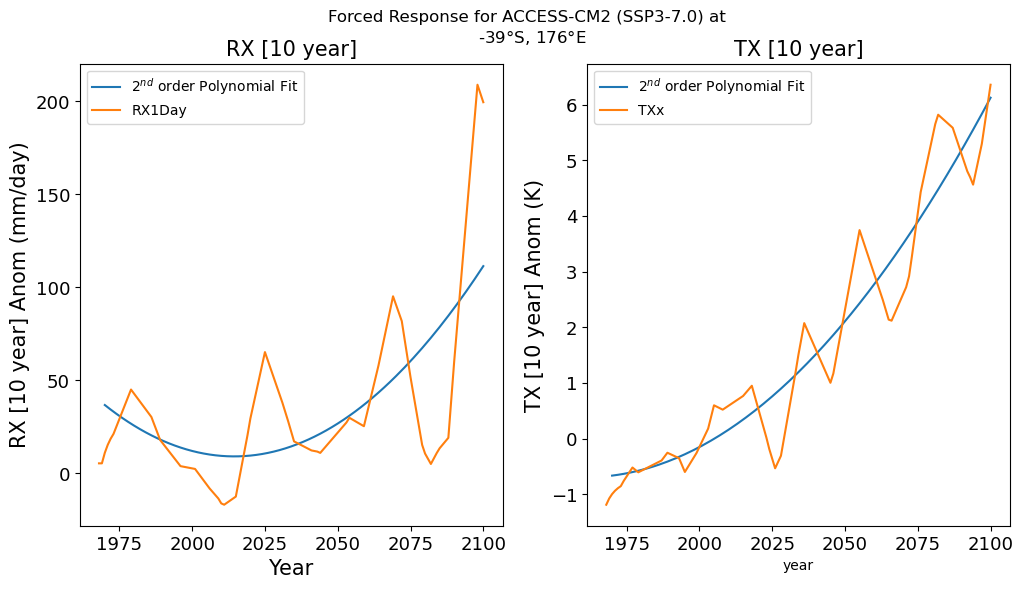

In [80]:
fig, ax = plt.subplots(1,2 , figsize = (12, 6), sharex=True)
fitted_T_rx1day_regional_max.sel(GCM ="ACCESS-CM2", ssp="ssp370").interp(lat =-39, lon =176).plot(ax = ax[0], label ='$2^{nd}$ order Polynomial Fit' )
clim_dset = pr_dset.sel(GCM ="ACCESS-CM2", ssp="ssp370").interp(lat =-39, lon =176).Rx1day_MME.rolling(year =10, min_periods =5).max().sel(year = slice("1986","2005")).mean("year")#.rolling(year =10, min_periods =5).mean()
(pr_dset.sel(GCM ="ACCESS-CM2", ssp="ssp370").interp(lat =-39, lon =176).Rx1day_MME.rolling(year =10, min_periods =5).max().rolling(year =10, min_periods =5).mean() - clim_dset).plot(ax = ax[0], label ='RX1Day')
clim_dset = t_dset.sel(GCM ="ACCESS-CM2", ssp="ssp370").interp(lat =-39, lon =176).TXX_MME.rolling(year =10, min_periods =5).max().sel(year = slice("1986","2005")).mean("year")#.rolling(year =10, min_periods =5).mean()

fitted_T_txx_regional_max.sel(GCM ="ACCESS-CM2", ssp="ssp370").interp(lat =-39, lon =176).plot(ax = ax[1], label ='$2^{nd}$ order Polynomial Fit' )
(t_dset.TXX_MME.sel(GCM ="ACCESS-CM2", ssp="ssp370").interp(lat =-39, lon =176).rolling(year =10, min_periods =5).max().rolling(year =10, min_periods =5).mean()-clim_dset).plot(ax=ax[1], label ='TXx')
ax[1].set_ylabel('TX [10 year] Anom (K)', fontsize =15,)
ax[0].set_ylabel('RX [10 year] Anom (mm/day)', fontsize = 15)
ax[0].tick_params(labelsize =13)
ax[1].tick_params(labelsize =13)
ax[0].set_xlabel('Year', fontsize =15)
ax[0].legend(fontsize =10)
ax[1].legend(fontsize =10)
ax[0].set_title('RX [10 year]', fontsize =15)
ax[1].set_title('TX [10 year]', fontsize =15)
fig.suptitle('Forced Response for ACCESS-CM2 (SSP3-7.0) at \n -39$\degree$S, 176$\degree$E', x= 0.5, y =0.97)
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/illustration_of_forced_response_10year_extremes_v170625.png', dpi =500, bbox_inches ='tight')

In [ ]:
I_model_txx_max, M_txx_max, S_txx_max, I_trend_A_txx_max, I_trend_C_txx_max, I_raw_A_txx_max, I_raw_C_txx_max,fitted_txx_max = compute_decomposition_decadal(t_dset.where(static_fields.orog>0, np.nan).mean(["lat","lon"]),
                                                                                              t_dset_le.where(static_fields.orog>0, np.nan).mean(["lat","lon"]), varname = "TXX_MME", dim ="year", degree =2, varname_iv = "TXX_IV")
I_model_txx_regional_max, M_txx_regional_max, S_txx_regional_max, I_trend_A_txx_regional_max, I_trend_C_txx_regional_max, I_raw_A_txx_regional_max, I_raw_C_txx_regional_max,fitted_T_txx_regional_max = compute_decomposition_decadal(t_dset,
                                                                                              t_dset_le, varname = "TXX_MME", dim ="year", degree =2, varname_iv = "TXX_IV")

In [ ]:
I_model_rx1day_max, M_rx1day_max, S_rx1day_max, I_trend_A_rx1day_max, I_trend_C_rx1day_max, I_raw_A_rx1day_max, I_raw_C_rx1day_max,fitted_rx1day_max = compute_decomposition_decadal(pr_dset.where(static_fields.orog>0, np.nan).mean(["lat","lon"]),
                                                                                              pr_dset_le.where(static_fields.orog>0, np.nan).mean(["lat","lon"]), varname = "Rx1day_MME", dim ="year", degree =2, varname_iv = "RX1Day_IV")
I_model_rx1day_regional_max, M_rx1day_regional_max, S_rx1day_regional_max, I_trend_A_rx1day_regional_max, I_trend_C_rx1day_regional_max, I_raw_A_rx1day_regional_max, I_raw_C_rx1day_regional_max,fitted_T_rx1day_regional_max = compute_decomposition_decadal(pr_dset,
                                                                                              pr_dset_le, varname = "Rx1day_MME", dim ="year", degree =2, varname_iv = "RX1Day_IV")

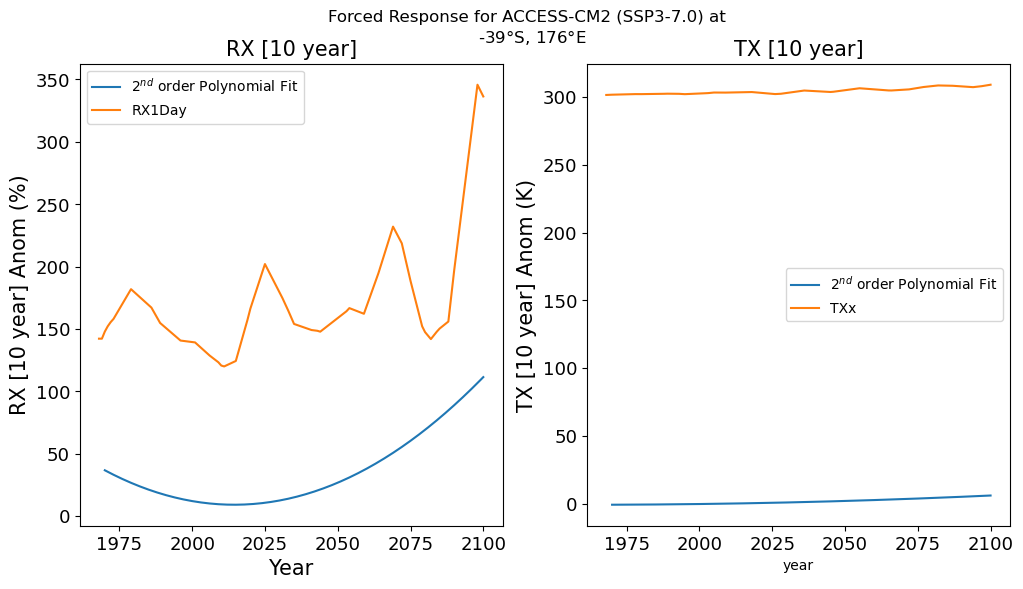